In [36]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from LSTM.radarnet import RadarNet as RadarLSTM
from GRU.model import RadarNet as RadarGRU
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# from torchvision.utils import SubSampler


In [37]:
# retrieve 10 radar images at one time
tsize=10

def retrieve_imgs(path):
    global tsize
    all_imgs= os.listdir(path)
    first='0000_20181123060000.tif'
    ind= all_imgs.index(first)
    if not isinstance(ind, int):
        raise ValueError('%s invalid!'%str(ind))
    while True:
        imgs_input= []
        imgs_target= []
        date_time= []
        for it in range(tsize):
            img_in= np.array(Image.open(os.path.join(radar_img_path, all_imgs[ind+it])))
            img_out= np.array(Image.open(os.path.join(radar_img_path, all_imgs[ind+it+1])))
            # store time
            date_str= all_imgs[ind+it+1].split('.')[0]
            # normalization
            img_in= img_in/img_in.max()
            img_out= img_out/img_out.max()
            imgs_input.append(img_in)
            imgs_target.append(img_out)
            date_time.append(date_str)
        
        return date_time, np.array(imgs_input)[np.newaxis,:,np.newaxis,400:600,400:600],\
                np.array(imgs_target)[np.newaxis,:,np.newaxis,400:600,400:600]
            

In [38]:
radar_img_path= '../ModelForecast/RadarRaw'
time, test_img_in, test_img_out= retrieve_imgs(radar_img_path)
LSTM_model_path= 'LSTM/logging/newest.pth'
GRU_model_path= 'GRU/logging/newest.pth'
print(test_img_in.shape)
# normalization
test_img_in= torch.Tensor(test_img_in)

(1, 10, 1, 200, 200)


In [ ]:
GRU= RadarGRU()
GRU.load_state_dict(torch.load(GRU_model_path, map_location='cpu'))
GRU.eval()
out= GRU(test_img_in)
print(out.shape)

In [ ]:
out_arr= out.detach().numpy().squeeze()
test_img_out= test_img_out.squeeze()

fig, ax= plt.subplots(1,2,figsize=(10,8))

def frame():
    global tsize, out_arr, test_img_out, time
    for it in range(tsize):
        yield time[it], out_arr[it], test_img_out[it]
    
def update(args):
    time= args[0]
    pred= args[1]
    target= args[2]
    im1=ax[0].imshow(pred)
    ax[0].set_title(time+' prediction')
    im2=ax[1].imshow(target)
    ax[1].set_title(time+' observation')
    plt.close()
    

ani= FuncAnimation(fig,update,frame, interval=100)


In [ ]:
# save results
ani.save('GRU-201811230600-predict.gif',writer='imagemagick')

## Gaussian Mixture Model

In [65]:
import cv2
import numpy as np
#for normalization + probability density function computation
from scipy import stats
from math import sqrt, log, exp, pi
from random import uniform
import seaborn as sns

torch.Size([200, 200])


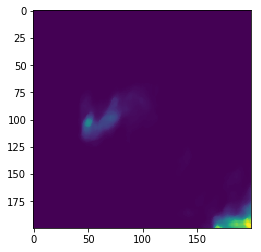

In [42]:
test_img= test_img_in.squeeze()[0]
print(test_img.shape)
plt.imshow(test_img)

In [52]:
data= test_img.detach().numpy()

In [74]:
# Gaussian Mixture Model
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, datum, mu, sigma):
        #mean and standard deviation
        self.datum= datum
        self.mu = mu 
        self.sigma = sigma
        x,y= datum.shape
        x_grid, y_grid= np.linspace(0,x,x), np.linspace(0,y,y)
        self.grid_x, self.grid_y= np.meshgrid(x_grid,y_grid)

    #probability density function
    def pdf(self):
        "Probability of a data point given the current parameters"
        u = (self.datum - self.mu) / abs(self.sigma) ##(200,200)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-(u**2) / 2)
        
        return y
    #printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
    
class GaussianMixture(object):
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=data.min(), mu_max=data.max(), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(data,uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(data,uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf() * self.mix
            wp2 = self.two.pdf() * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for wp1, wp2 in self.Estep():
            self.Mstep((wp1,wp2))

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [60]:
gaussian=Gaussian(data, data.mean(), data.std())

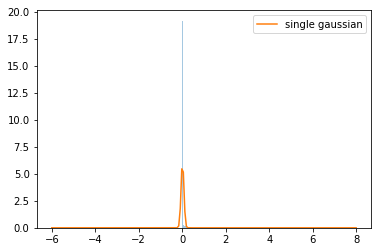

In [70]:
x = np.linspace(-6, 8, 200)
g_single = stats.norm(gaussian.mu, gaussian.sigma).pdf(x)
sns.distplot(data.reshape(-1,1), bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [56]:
data.max()

1.0

In [75]:
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

TypeError: only size-1 arrays can be converted to Python scalars